# Cats and Dogs image classification
Author: Andrii Zapukhlyi

## Import packages and data


Images are located in train and test folders and divided into two class folders - cats and dogs.
At first, I'll build a classifier from scratch only using NumPy, so I need to import images as numpy arrays.
I built the function `load_images_from_folder` to save all images as 2 arrays. First (`images`) - for encoded images, second (`labels`) - for their labels. <br>

Cats will have label 0, dogs - label 1

In [88]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images_from_folder(folder, label, img_size=(150, 150)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, )
        if img is not None:
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)
    return images, labels

train_cats = 'train/cats'
train_dogs = 'train/dogs'
test_cats = 'test/cats'
test_dogs = 'test/dogs'

cat_images_train, cat_labels_train = load_images_from_folder(train_cats, label=0)
dog_images_train, dog_labels_train = load_images_from_folder(train_dogs, label=1)
cat_images_test, cat_labels_test = load_images_from_folder(test_cats, label=0)
dog_images_test, dog_labels_test = load_images_from_folder(test_dogs, label=1)

I resized all images to 150x150 pixels to ensure uniformity.
Additionally, since the cv2 library imports images in BGR format by default, I converted them to RGB format. <br>
After these preprocessing steps, I initialized the variables X and Y, where X represents the images and Y represents the labels.

## Images already have been split into train/test sets, why combine them and divide them again?

Because I should shuffle them, to avoid algorithms learning from patterns that at first there are images with cats, then images with dogs <br>
Moreover, I'm not sure if the distribution of images in train and test folders is similar <br>
P.S It can be done using permutation or other technique

In [89]:
X = np.array(cat_images_train + dog_images_train + cat_images_test + dog_images_test)
Y = np.array(cat_labels_train + dog_labels_train + cat_labels_test + dog_labels_test)

## Data overview

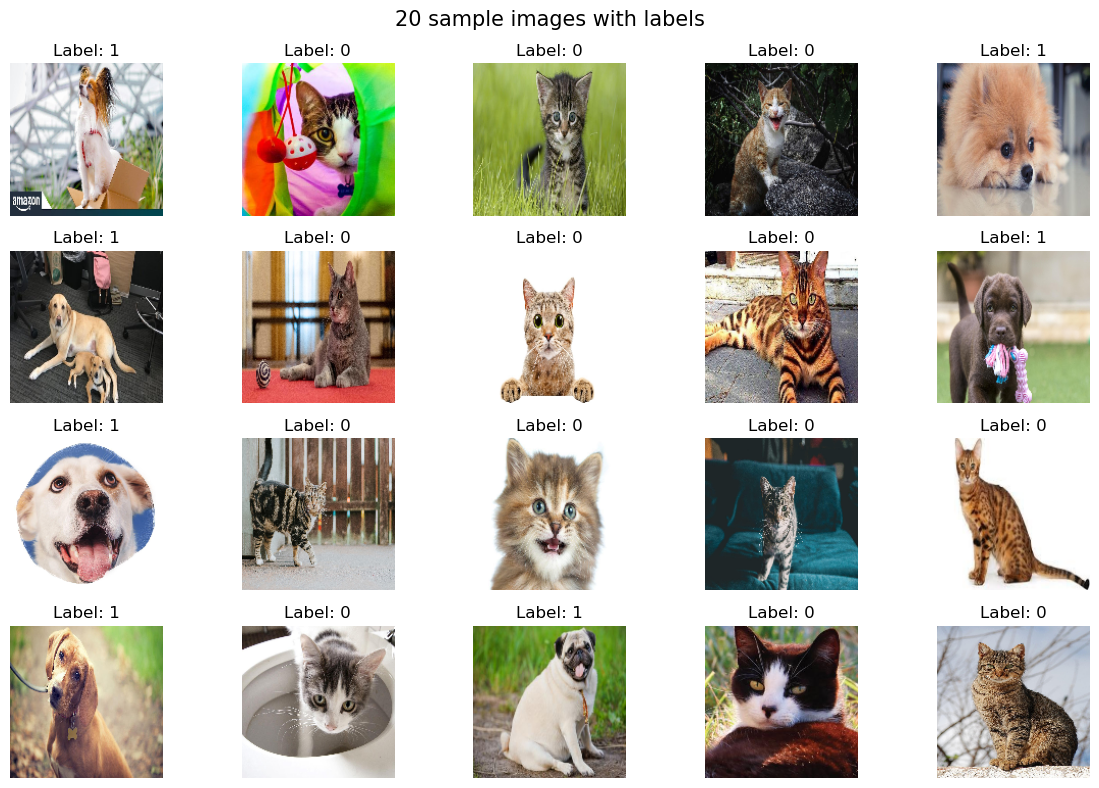

In [90]:
indexes = np.random.choice(range(len(X)), 20, replace=False)
fig, axes = plt.subplots(4, 5, figsize=(12, 8)) 

for idx, ax in zip(indexes, axes.flatten()):
    ax.imshow(X[idx])  
    ax.set_title(f"Label: {Y[idx]}")
    ax.axis('off')

plt.suptitle("20 sample images with labels", fontsize=15)
plt.tight_layout()
plt.show()

From the sample images above we can see, that all `dogs` labeled as `1` and all `cats` labeled as`0`

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Split images and labels into train and test sets with an 80/20 ratio, because I have a small number of images

In [92]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (467, 150, 150, 3)
X_test shape: (117, 150, 150, 3)
y_train shape: (467,)
y_test shape: (117,)


In [93]:
print(f"Resolution of each image: {X_train.shape[1]}x{X_train.shape[2]}")
print("Number of training examples:", X_train.shape[0])
print("Number of test examples:", X_test.shape[0])

Resolution of each image: 150x150
Number of training examples: 467
Number of test examples: 117


For convenience, I'll reshape images of shape (num_px, num_px, 3) in a NumPy array of shape (num_px * num_px * 3, 1) <br> 
After this, the training (and test) dataset is a numpy-array where each column represents a flattened image. There will be m_train (respectively m_test) columns

In [94]:
X_train = X_train.reshape(X_train.shape[0], -1).T 
X_test = X_test.reshape(X_test.shape[0], -1).T  
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (67500, 467)
X_test shape: (67500, 117)
y_train shape: (1, 467)
y_test shape: (1, 117)


## Data standardization

Before building the models I standardize the data to a normalized range of [0, 1]. All pixel values for RGB images range from 0 to 255, to convert values into [0, 1] I divide them by 255. Standardization images improve training stability of ML algorithms 

In [95]:
X_train = X_train / 255.
X_test = X_test / 255.

## General Architecture of the learning algorithm
The image below shows the architecture of the algorithm <br>
Logistic regression is a very simple Neural Network, having only an output layer with 1 unit. <br>
I already implemented encoding images to numpy vector and standardization of the images. Now I have to create this main unit, that will predict is passed image dog or cat. <br>
To do this, I'll create some functions to a build Logistic Regression model <br> <br>
<img src = "https://raw.githubusercontent.com/knazeri/coursera/e3121069a1c8c02ff01caf18f90df06cdbb9292d/deep-learning/1-neural-networks-and-deep-learning/2-logistic-regression-as-a-neural-network/images/LogReg_kiank.png" alt = "general architecture img">


<p align="center">Picture 1: General architecture of the learning algorithm</p>

The main function responsible for binary classification is a `sigmoid function`, which returns the probability that this image is a dog (because the dog is labeled as 1)

Formula:
$$
Sigmoid(z) = \dfrac{1}{1 + e^{-z}}
$$

In [96]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In classification models, algorithm calculates the probability that a specific image $x^{(i)}$ is labeled as 1. So it should look like sigmoid($x^{(i)}$)? Not exactly. <br>
The fact is that each image is a vector of features and some features can be more informative than others and algorithm must detect this or in other words learn this. <br>
For this purpose, we must have some vector of weights (w on Picture 2), that algorithm will update to find the best values and learn more or less informative features. <br>
These weights are multiplied by X and added bias to it, then this equation is passed into a sigmoid function, so sigmoid($W^T \cdot X + b$), where "$\cdot$" matrix multiplication, not element-wise

Moreover, logistic regression aims to classify data into two categories by finding a boundary that best separates these classes. <br>
The term $W^T \cdot X + b$ defines a hyperplane that represents this boundary. <br>
So matrix (vector in this case) of weights is an essential part of the accurate algorithm, but how to find the best weights?

## Gradient Descent
<img src = "https://miro.medium.com/v2/resize:fit:1200/1*3BIDGdKjh88SLF0YTBz5oA.png">

<p align="center">Picture 2: Gradient Descent</p>

Machine learning algorithms use `Gradient Descent` to find the global minimum of the cost function J, `determining the best parameters` (such as $\theta_0$ and $\theta_1$ in the image above). <br>
The cost function measures how far the algorithm's predictions are from the actual values with the current parameters. <br>
In our case, $\theta_0$ and $\theta_1$ are W (vector of weights) and b (bias). These parameters should have some initialization values before the algorithm starts finding the best values for them. <br>
<br>
When building more complex Machine Learning models, `initialization of parameters is a crucial step`, because it avoids vanishing/exploding gradients in the neural networks. <br>
There are initialization methods like `He initialization` or `Xavier initialization`, but for my simple task, I just use zero initialization, because my network is not such deep.

In [97]:
def initialize_parameters_zeros(dim):
    W = np.zeros([dim, 1])
    b = 0
    return W, b

## Cost function
There are `Loss` and `Cost` functions for logistic regression, where Loss shows how far the algorithm's predictions are from the actual values. Cost function is the sum of Losses divided by the number of examples. <br><br>
Simplified Loss function is defined as:
$$L(y^{(i)}, \hat{y}^{(i)}) = -y^{(i)}\log{(\hat{y}^{(i)})}-(1-y^{(i)})\log{(1-\hat{y}^{(i)})}$$
where $y^{(i)}$ is true label and $\hat{y}^{(i)}$ algorithm's prediction <br>
Cost function:
$$J(W, b) = \dfrac{1}{m}\sum_{i=1}^{m}{L(y^{(i)}, \hat{y}^{(i)})}$$
where m is the number of examples

In [98]:
def compute_cost(y_true, y_pred):
    m = y_true.shape[1]
    cost = -np.sum(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
    cost /= m
    return cost

## Forward and Backward propagation

<img src = "https://scientistcafe.com/ids/images/dnn0_fb3.png">

<p align="center">Picture 3: Forward and Backward propagation</p>

So, Gradient Descent is an optimization algorithm that iteratively updates parameters to minimize the cost function J(W,b). <br>
To perform a single update step, the algorithm requires two key components:

1. Step Size (Learning Rate): The learning rate, denoted as $\alpha$, is a hyperparameter set by the user that controls the magnitude of each step taken in the parameter space
2. Direction of the Step: The direction in which to update the parameters is determined by the gradients of the cost function with respect to the parameters W and b. Specifically, these gradients are the partial derivatives $\dfrac{\partial J}{\partial W}$ and $\dfrac{\partial J}{\partial b}$

During training algorithm do forward propagation (make predictions with selected W and b), then calculate loss, then do backward propagation (calculate derivatives) and update the parameters. <br>
<br>
Using chain rule from calculus and linear algebra partial derivatives $\dfrac{\partial J}{\partial W}$ and $\dfrac{\partial J}{\partial b}$ are defined:
$$\dfrac{\partial J}{\partial W} = \dfrac{1}{m}X(\hat{Y}-Y)^T$$
$$\dfrac{\partial J}{\partial b} = \dfrac{1}{m}\sum_{i=1}^m(\hat{y}^{(i)} - y^{(i)})$$
Vectorized implementation of this:

In [99]:
def propagate(W, b, X, Y):
    m = X.shape[1]
    Y_hat = sigmoid(np.dot(W.T, X) + b)
    
    cost = compute_cost(Y, Y_hat)

    dw = np.dot(X, (Y_hat - Y).T) / m
    db = np.sum(Y_hat - Y) / m

    gradients = {
        "dw": dw,
        "db": db
    }
    return cost, gradients

After propagation algorithm can update the parameters W and b:
$$W = W - \alpha*\dfrac{\partial J}{\partial W}$$
$$b = b - \alpha*\dfrac{\partial J}{\partial b}$$
where $\alpha$ is learning rate (step size)

In [100]:
def update_parameters(W, b, X, Y, num_iterations, learning_rate):
    costs = []

    for i in range(num_iterations):
        cost, gradients = propagate(W, b, X, Y)
        dw = gradients["dw"]
        db = gradients["db"]

        W -= learning_rate * dw
        b -= learning_rate * db

        costs.append(cost)

        if i % 100 == 0:
            print(f"Num of iterations: {i}, Cost: {cost}")

    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.title(f'Learning rate = {learning_rate}')
    plt.show()
    return W, b

Besides, this function will print the Cost for every 100 iterations and after iterating create the chart to visualize the changes in cost during training

## Prediction

Now, the model can predict labels with new data using parameters W and b, gained from training. <br> <br>
Also, probabilities are converted into binary type 0 or 1 using a threshold (0.5 in this case).

In [101]:
def predict(W, b, X):    
    Y_hat = sigmoid(np.dot(W.T, X) + b)
    Y_pred = (Y_hat > 0.5).astype(int)
    return Y_pred

## Modeling

In the end, having all functions defined we can implement the last one - to create the model. <br>
Algorithm takes from user train and test sets with data, number of iterations and learning rate. <br>
Function returns a dictionary with predictions and model's accuracy on the test set

In [102]:
def model(X_train, y_train, X_test, y_test, num_iterations, learning_rate):
    W, b = initialize_parameters_zeros(X_train.shape[0])

    W, b = update_parameters(W, b, X_train, y_train, num_iterations, learning_rate)

    y_prediction_test = predict(W, b, X_test)
    y_prediction_train = predict(W, b, X_train)

    test_accuracy = np.sum(y_prediction_test == y_test.flatten()) / len(y_test.flatten())
    train_accuracy = np.sum(y_prediction_train == y_train.flatten()) / len(y_train.flatten())

    print(f"Test accuracy: {round(test_accuracy*100)}%")
    print(f"Train accuracy: {round(train_accuracy*100)}%")
    d = {
         "y_prediction_test": y_prediction_test, 
         "y_prediction_train" : y_prediction_train,
         "test_accuracy": test_accuracy
    }
    
    return d

Num of iterations: 0, Cost: 0.6931471805599452
Num of iterations: 100, Cost: 0.667526627589781
Num of iterations: 200, Cost: 0.6492680137244043
Num of iterations: 300, Cost: 0.6345095856174044
Num of iterations: 400, Cost: 0.6218545064992774
Num of iterations: 500, Cost: 0.6106536366149531
Num of iterations: 600, Cost: 0.6005486770818362
Num of iterations: 700, Cost: 0.5913133823446639
Num of iterations: 800, Cost: 0.582791072582988
Num of iterations: 900, Cost: 0.5748664625023765


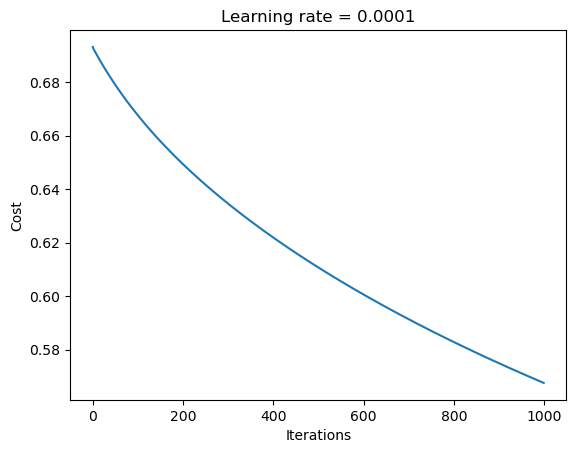

Test accuracy: 63%
Train accuracy: 78%


In [103]:
model_lr = model(X_train, y_train, X_test, y_test, 1000, 0.0001)

Created model with hyperparameters: number of iterations - 1000 and learning rate - 0.0001 after training achieves 63% accuracy on the test set and 78% on the train set. <br>
Results show that model is overfitted on train data because I did not avoid it during model building <br>
Moreover, test accuracy is not such high, which can occur for some reasons: 
1. Small dataset
2. Simple model (1 layer with 1 unit)

In [104]:
models_accuracy = np.array([[]])
models_accuracy = np.append(models_accuracy, model_lr["test_accuracy"])

I'll use numpy array with the accuracy scores of the created models to compare them  

### Example of the wrong classified image

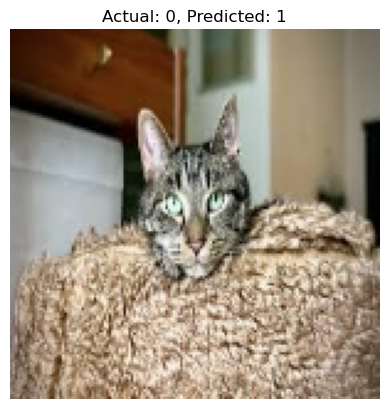

In [105]:
index = 2
plt.imshow(X_test[:, index].reshape((150, 150, 3)))  
plt.title(f"Actual: {y_test[0][index]}, Predicted: {model_lr['y_prediction_test'][0, index]}")
plt.axis('off')
plt.show()

## More complex model

I'll build a more complex model than Logistic Regression. This time I'm going to use Keras library. <br>
The model structure: 
- Dense layer with 256 neurons and ReLU activation function
- Dropout layer with 0.3 dropout rate to avoid overfitting
- Dense layer with 128 neurons and ReLU activation function
- Dropout layer with 0.3 dropout rate to avoid overfitting
- Output dense layer with 1 neuron and sigmoid activation function

Model uses SGD (Stochastic Gradient Descent) algorithm and 128 batch size. Besides, there is a learning rate scheduler to reduce the learning rate when a metric has stopped improving. <br>
Learning rate is set to 0.01 and number of epochs is 10

Epoch 1/10


2024-11-02 23:51:39.694349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.4880 - loss: 1.5349 - learning_rate: 0.0100
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4626 - loss: 0.8582 - learning_rate: 0.0100
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5158 - loss: 0.7427 - learning_rate: 0.0100
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5633 - loss: 0.7005 - learning_rate: 0.0100
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5458 - loss: 0.6965 - learning_rate: 0.0100
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4865 - loss: 0.7101 - learning_rate: 0.0100
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5485 - loss: 0.6950 - learning_rate: 0.0100
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5165 - loss: 0.7045 - learning_rate: 0.0100
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5057 - loss: 0.7083 - learning_rate: 0.0100
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/st

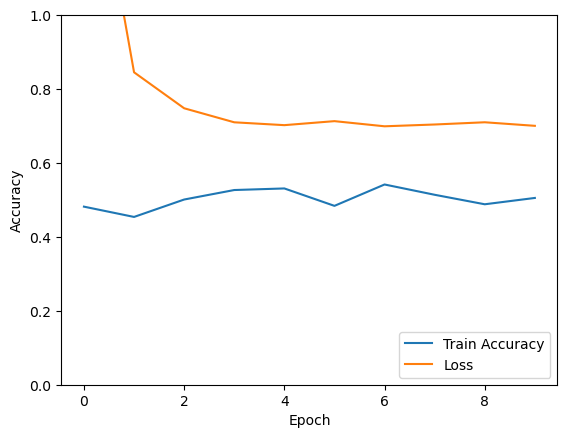

Test Accuracy: 62%, Test Loss: 0.680063009262085
Train Accuracy: 62%, Train Loss: 0.680380642414093


In [106]:
from keras import layers, models, callbacks
import random
import tensorflow as tf

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

X_train_model = X_train.T
X_test_model = X_test.T 

y_train_model = y_train.flatten()
y_test_model = y_test.flatten()

model_dense = models.Sequential([
    layers.InputLayer((X_train.shape[0], )),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_dense.compile(optimizer='sgd', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)

history = model_dense.fit(
    X_train_model, y_train_model, 
    epochs=10, 
    batch_size=128,
    callbacks=[reduce_lr]
)

test_loss, test_accuracy = model_dense.evaluate(X_test_model, y_test_model)
train_loss, train_accuracy = model_dense.evaluate(X_train_model, y_train_model)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0,1])
plt.show()

print(f'Test Accuracy: {round(test_accuracy*100)}%, Test Loss: {test_loss}')
print(f'Train Accuracy: {round(train_accuracy*100)}%, Train Loss: {train_loss}')

models_accuracy = np.append(models_accuracy, test_accuracy)

This model fixes high variance (overfitting) compared to the first model, but test accuracy again low

## CNN Model
Convolutional Neural Networks (CNNs) are the de facto standard in computer vision and image processing. <br> CNNs learn fundamental patterns, such as edges and textures, which they use to recognize features across an entire image. <br> Furthermore, this type of network requires significantly fewer parameters than a Dense network, making it more efficient and well-suited for complex visual data.

To avoid overfitting and improve generalization, I will apply real-time data augmentation and re-import the images using `ImageDataGenerator` from the Keras library.

In [107]:
from tensorflow.keras import preprocessing #type: ignore

img_width, img_height = 150, 150
batch_size = 32

train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    zoom_range=0.3,  
    shear_range=0.3,  
    rotation_range=30,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  
)

train_generator = train_datagen.flow_from_directory(
    "./train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

validation_datagen = preprocessing.image.ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    "./train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

test_datagen = preprocessing.image.ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    './test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 374 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


## CNN model structure
- Conv2D layer with 32 filters 3x3 and ReLU activation function
- MaxPool 2x2 layer
- Conv2D layer with 64 filters 3x3 and ReLU activation function
- MaxPool 2x2 layer
- Conv2D layer with 128 filters 3x3 and ReLU activation function
- MaxPool 2x2 layer
- Flatten layer
- Dense layer with 128 neurons and ReLU activation function
- Dropout layer with 0.3 dropout ratio
- Output dense layer with 1 neuron and sigmoid activation function

The model uses the Adam (Adaptive Moment Estimation) optimizer with a batch size of 32. <br>
Additionally, a learning rate scheduler is applied, and the model is trained for 20 epochs.

/Users/andrik/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 658ms/step - accuracy: 0.5133 - loss: 0.8803 - val_accuracy: 0.5109 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.4446 - loss: 0.7073 - val_accuracy: 0.5000 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step - accuracy: 0.5711 - loss: 0.6900 - val_accuracy: 0.5000 - val_loss: 0.7070 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - accuracy: 0.5152 - loss: 0.6960 - val_accuracy: 0.5109 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.5200 - loss: 0.6860 - val_accuracy: 0.5652 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.5590 - loss: 0.6792 - val_accuracy: 0.5326 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.4850 - loss: 0.6829 -

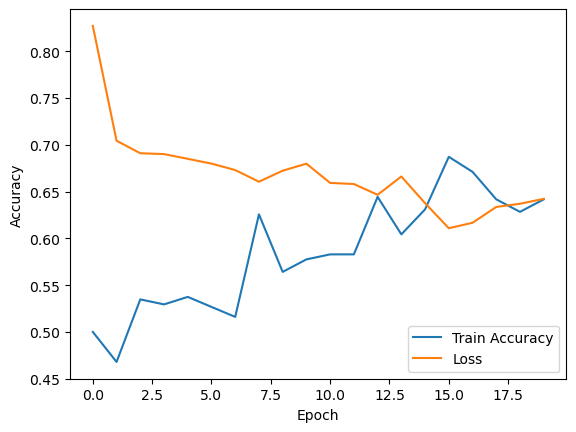

Test Accuracy: 62%, Test Loss: 0.6373066306114197
Train Accuracy: 66%, Train Loss: 0.6040539145469666


In [108]:
model_cnn = models.Sequential([
    layers.InputLayer((img_width, img_height, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[reduce_lr]
)

test_loss, test_accuracy = model_cnn.evaluate(test_generator)
train_loss, train_accuracy = model_cnn.evaluate(train_generator)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

print(f'Test Accuracy: {round(test_accuracy*100)}%, Test Loss: {test_loss}')
print(f'Train Accuracy: {round(train_accuracy*100)}%, Train Loss: {train_loss}')

models_accuracy = np.append(models_accuracy, test_accuracy)

Model achieved 62% accuracy and it's slightly overfitted

## Problem Overview
All the models built have achieved an accuracy of around 60%, which is poor for image classification, especially considering that humans can achieve nearly 100% accuracy in classifying images of cats and dogs. <br>
The primary issue arises from the small training set; neither a shallow, simple network nor a deeper CNN can effectively learn patterns from such a limited sample of images. <br>
To address this problem, I will use `Transfer Learning`.

## Transfer Learning

Transfer Learning - is a machine learning technique in which knowledge gained through one task or dataset is used to improve model performance on another related task. <br>
I will use models trained on `imagenet` dataset to solve my problem  

## VGG16

<img src = "https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16.jpg">
<p align="center">Picture 4: VGG16 Architecture</p>

I'll fine-tune the last 3 layers in VGG16 and add:
- GlobalAveragePooling layer
- Dense layer with 128 neurons and ReLU activation function
- BatchNormalization layer
- Dropout layer with 0.3 dropout ratio
- Dense layer with 1 neuron and sigmoid activation function

The model uses SGD with a batch size of 32 and trained for 20 epochs

Epoch 1/20


2024-11-02 23:53:57.183823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 858ms/step - accuracy: 0.6496 - loss: 0.6859 - val_accuracy: 0.6522 - val_loss: 0.5595
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 790ms/step - accuracy: 0.7900 - loss: 0.4935 - val_accuracy: 0.7283 - val_loss: 0.5114
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 773ms/step - accuracy: 0.8215 - loss: 0.4002 - val_accuracy: 0.7935 - val_loss: 0.4658
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 771ms/step - accuracy: 0.8294 - loss: 0.3342 - val_accuracy: 0.9130 - val_loss: 0.3626
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 764ms/step - accuracy: 0.8783 - loss: 0.2627 - val_accuracy: 0.9130 - val_loss: 0.3364
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 809ms/step - accuracy: 0.8673 - loss: 0.3018 - val_accuracy: 0.7283 - val_loss: 0.4529
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 804ms/step - accuracy: 0.8915 - loss: 0.2501 - val_accuracy: 0.8261 - val_loss: 0.3770
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 760ms/step - accuracy: 0.8731 - loss: 0.2365 - val_accuracy: 0.9239 - v

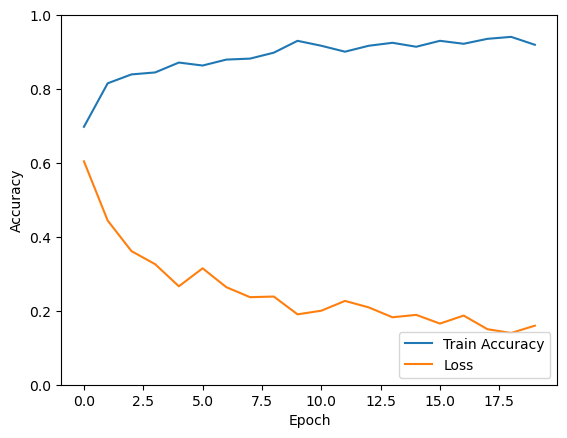

Test Accuracy: 86%, Test Loss: 0.3728206753730774
Train Accuracy: 83%, Train Loss: 0.3458032011985779


In [109]:
from keras import applications

vgg_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
for layer in vgg_base.layers[:-3]:
    layer.trainable = False

x = vgg_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model_vgg = models.Model(inputs=vgg_base.input, outputs=x)
model_vgg.compile(optimizer="sgd", loss='binary_crossentropy', metrics=['accuracy'])
history = model_vgg.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

test_loss, test_accuracy = model_vgg.evaluate(test_generator)
train_loss, train_accuracy = model_vgg.evaluate(train_generator)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

print(f'Test Accuracy: {round(test_accuracy*100)}%, Test Loss: {test_loss}')
print(f'Train Accuracy: {round(train_accuracy*100)}%, Train Loss: {train_loss}')

models_accuracy = np.append(models_accuracy, test_accuracy)

## ResNet50
<img src="https://miro.medium.com/v2/resize:fit:1400/0*tH9evuOFqk8F41FG.png">
<p align="center">Picture 5: ResNet50 Architecture</p>

ResNet50 is a much deeper network than VGG16 and uses residual (skip) connections, which allows to build deeper models without overfitting <br> 
I don't fine-tune trained model and add a few layers:
- Flatten layer
- Dense layer with 128 neurons and ReLU activation function
- BatchNormalization layer
- Dropout layer with 0.3 dropout ratio
- Dense layer with 1 neuron and sigmoid activation function

The model uses RMSprop (Root Mean Squared Propagation) with a batch size of 32 and trained for 20 epochs

Epoch 1/20


2024-11-02 23:57:24.427082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5158 - loss: 1.1898 - val_accuracy: 0.5000 - val_loss: 1.8635
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step - accuracy: 0.5983 - loss: 0.6871 - val_accuracy: 0.5000 - val_loss: 0.9261
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 623ms/step - accuracy: 0.6273 - loss: 0.6359 - val_accuracy: 0.5000 - val_loss: 1.6843
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 634ms/step - accuracy: 0.6001 - loss: 0.6726 - val_accuracy: 0.5000 - val_loss: 1.0782
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 641ms/step - accuracy: 0.5751 - loss: 0.7070 - val_accuracy: 0.5109 - val_loss: 0.8536
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 608ms/step - accuracy: 0.5985 - loss: 0.6765 - val_accuracy: 0.5000 - val_loss: 2.1707
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 614ms/step - accuracy: 0.6363 - loss: 0.6750 - val_accuracy: 0.5543 - val_loss: 0.8994
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 622ms/step - accuracy: 0.6142 - loss: 0.6788 - val_accuracy: 0.5217 - val_lo

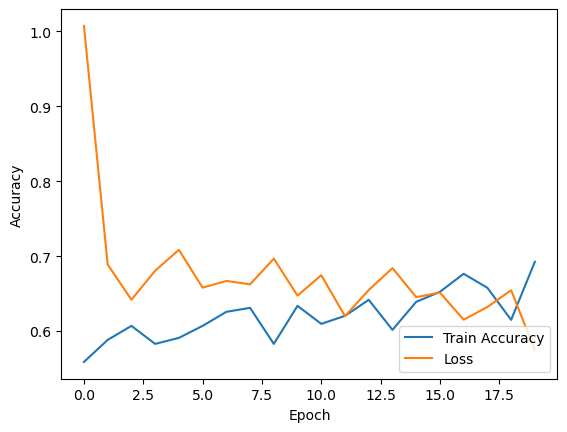

Test Accuracy: 69%, Test Loss: 0.5575998425483704
Train Accuracy: 69%, Train Loss: 0.5996350049972534


In [110]:
resnet_base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

for layer in resnet_base.layers:
    layer.trainable = False

x = resnet_base.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model_resnet = models.Model(inputs=resnet_base.input, outputs=x)
model_resnet.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
history = model_resnet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

test_loss, test_accuracy = model_resnet.evaluate(test_generator)
train_loss, train_accuracy = model_resnet.evaluate(train_generator)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

print(f'Test Accuracy: {round(test_accuracy*100)}%, Test Loss: {test_loss}')
print(f'Train Accuracy: {round(train_accuracy*100)}%, Train Loss: {train_loss}')

models_accuracy = np.append(models_accuracy, test_accuracy)

## InceptionV3
<img src="https://production-media.paperswithcode.com/methods/inceptionv3onc--oview_vjAbOfw.png">
<p align="center">Picture 6: InceptionV3 Architecture</p>

InceptionV3 uses inception modules in its architecture, which also allows to building more deeper models <br> <br>
<img src = "https://miro.medium.com/v2/resize:fit:400/1*hp93DT_YP2RfPs7eBDtPfw.jpeg">
<p align="center">Picture 7: Inception</p>

I added the same layers as in ResNet50:
- Flatten layer
- Dense layer with 128 neurons and ReLU activation function
- BatchNormalization layer
- Dropout layer with 0.3 dropout ratio
- Dense layer with 1 neuron and sigmoid activation function

However, this model uses ADAM with a batch size of 32 and trained for 20 epochs

Epoch 1/20


2024-11-03 00:00:52.159551: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8151 - loss: 0.4104 - val_accuracy: 0.9239 - val_loss: 0.7617
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 576ms/step - accuracy: 0.9112 - loss: 0.2129 - val_accuracy: 0.9565 - val_loss: 0.1355
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 541ms/step - accuracy: 0.9200 - loss: 0.2298 - val_accuracy: 0.9348 - val_loss: 0.1879
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.9223 - loss: 0.1834 - val_accuracy: 0.9565 - val_loss: 0.0850
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.9191 - loss: 0.1903 - val_accuracy: 0.9783 - val_loss: 0.0840
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step - accuracy: 0.9364 - loss: 0.1664 - val_accuracy: 0.9783 - val_loss: 0.0728
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.9094 - loss: 0.2086 - val_accuracy: 0.9674 - val_loss: 0.0447
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - accuracy: 0.9588 - loss: 0.1072 - val_accuracy: 0.9783 - val_lo

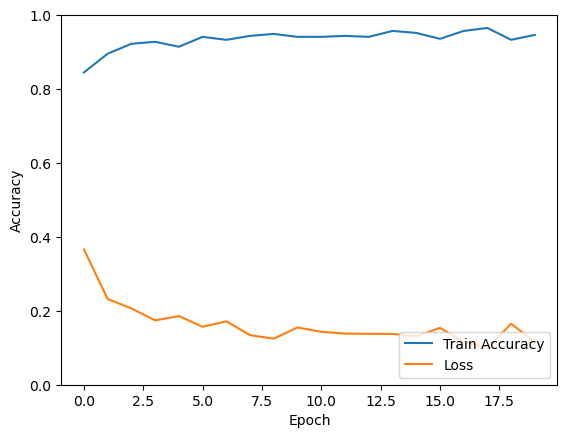

Test Accuracy: 95%, Test Loss: 0.11995317041873932
Train Accuracy: 97%, Train Loss: 0.07124990224838257


In [111]:
inception_base = applications.InceptionV3(include_top=False, input_shape=(img_width, img_height, 3))

for layer in inception_base.layers:
    layer.trainable = False

x = inception_base.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model_inception = models.Model(inputs=inception_base.input, outputs=x)

model_inception.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
history = model_inception.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

test_loss, test_accuracy = model_inception.evaluate(test_generator)
train_loss, train_accuracy = model_inception.evaluate(train_generator)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

print(f'Test Accuracy: {round(test_accuracy*100)}%, Test Loss: {test_loss}')
print(f'Train Accuracy: {round(train_accuracy*100)}%, Train Loss: {train_loss}')

models_accuracy = np.append(models_accuracy, test_accuracy)

## Model selection
I have added the accuracy scores of all models into a NumPy array. <br>I will create a bar plot to visualize these scores and identify the most accurate model

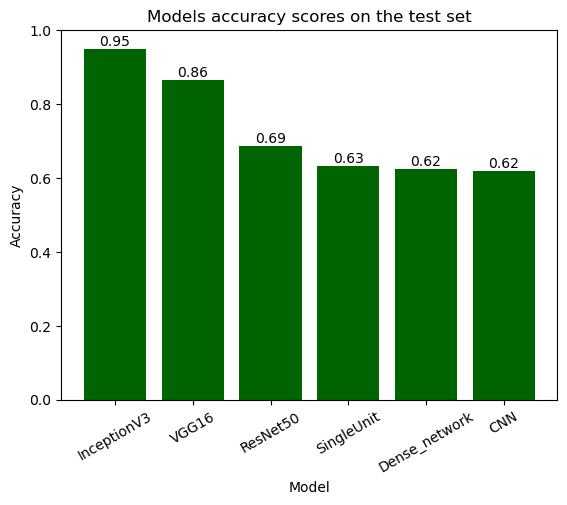

In [114]:
import pandas as pd
df_accuracy = pd.DataFrame(models_accuracy, columns=["accuracy"])
df_accuracy.insert(1, "model", ["SingleUnit", "Dense_network", "CNN", "VGG16", "ResNet50", "InceptionV3"])
df_accuracy = df_accuracy.sort_values("accuracy", ascending = False)

barplot = plt.bar(df_accuracy.model, df_accuracy.accuracy, color = 'darkgreen')
plt.bar_label(barplot, fmt='{:,.2f}')
plt.ylim([0,1])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.title("Models accuracy scores on the test set")
plt.show()

The chart above demonstrates that Transfer Learning significantly improved prediction accuracy, with the InceptionV3 model achieving the best accuracy of 95%

## Example of prediction 

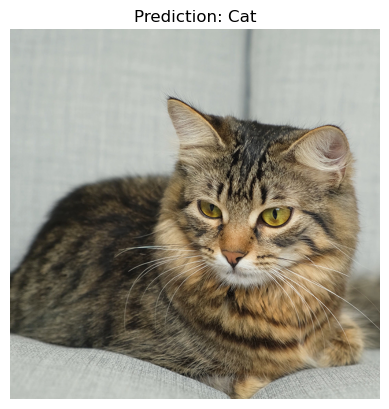

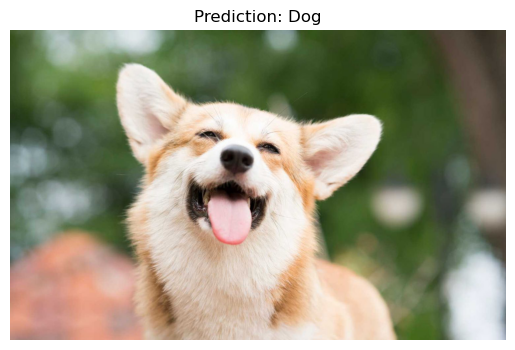

In [122]:
def load_and_preprocess_image(img_path):
    img = preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    img_array = preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_example(img_path):
    img_array = load_and_preprocess_image(img_path)

    prediction = model_inception.predict(img_array, verbose=0)

    if prediction[0] > 0.5:
        prediction = "Dog"
    else:
        prediction = "Cat"

    plt.imshow(preprocessing.image.load_img(img_path))
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')
    plt.show()

predict_example("example_cat.jpg")
predict_example("example_dog.jpg")

## Export model

In [123]:
model_inception.save('model.keras')

## Conclusion

In this project, I built a cat and dog image classifier, starting with models from scratch using NumPy. Limited by a small dataset, initial models achieved only around 60% accuracy. To address this, I used Transfer Learning, which significantly improved performance by leveraging pre-trained models. The InceptionV3 model achieved the highest accuracy at 95%, highlighting how Transfer Learning can effectively boost performance with limited data

## Thanks for reading